In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os

In [2]:
train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
train.shape

(50272, 2)

In [4]:
train.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
train['Defect'] = train['EncodedPixels'].notnull()
train['ClassId'] = train['ImageId_ClassId'].str[-1:]
train['ImageId'] = train['ImageId_ClassId'].str[:-2]

In [6]:
train.shape

(50272, 5)

In [7]:
train.head()

,ImageId_ClassId,EncodedPixels,Defect,ClassId,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,True,1,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,False,2,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,False,3,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,False,4,0002cc93b.jpg
4,00031f466.jpg_1,NaN,False,1,00031f466.jpg


In [8]:
train = train[['ImageId','ClassId','Defect','EncodedPixels']]

In [9]:
train.shape

(50272, 4)

In [10]:
train.head()

,ImageId,ClassId,Defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


In [11]:
train = train[train.Defect]

In [12]:
train.shape

(7095, 4)

In [13]:
train.head()

,ImageId,ClassId,Defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [14]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0
    
    print(tmp)

    tmp = tmp.reshape(-1,1)   
    print(tmp)
    
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [15]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

[[0 0 0 0 0]
 [1 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 0]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
5 4 11 1 13 1 16 4


In [36]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, imgshape=(1600,256)):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    #print(mask)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    #print(mask.reshape(height, width))
    #print(np.rot90( mask.reshape(height, width), k=1 ))
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [26]:
res = rle2mask("5 4 11 1 13 1 16 4", (5, 5))
print(res)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0 0 0 0 0]
 [1 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 0]]
[[0 0 0 1 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 1 0 0 0]]
[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


In [18]:
# This function uses a 1 based start index (arrays, matrixes and imgs start a index 1)
def rle2mask_eda(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    print(img.reshape(shape))
    return img.reshape(shape).T

In [19]:
res = rle2mask_eda("6 4 12 1 14 1 17 4", (5, 5))
print(res)

[[0 0 0 0 0]
 [1 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 0]]
[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


#### back to the data

In [20]:
train['EncodedPixels'].iloc[1]

'18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63'

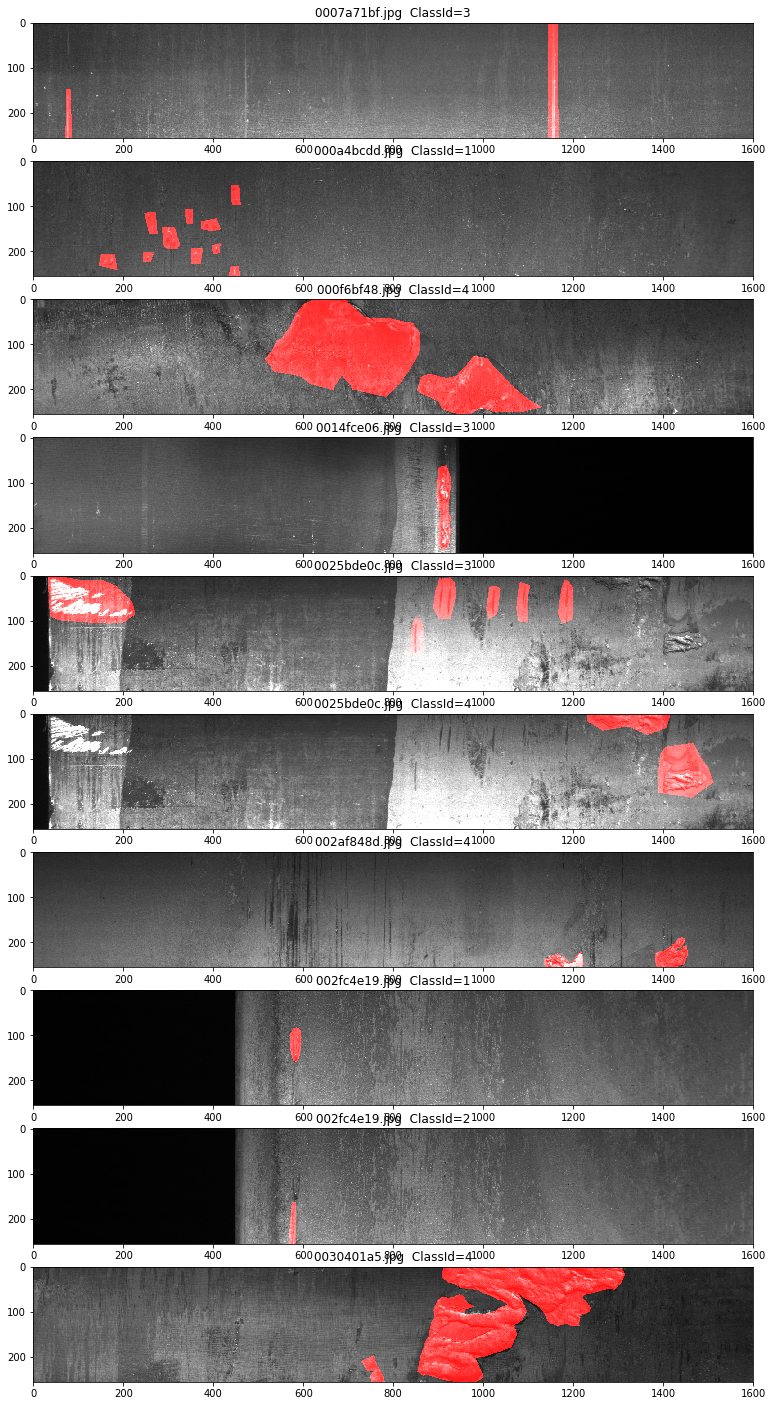

In [37]:
rows = 10
fig = plt.figure(figsize=(25, 25))
for i in range(1,rows+1):
    fn = train['ImageId'].iloc[i]
    c = train['ClassId'].iloc[i]
    fig.add_subplot(rows, 1, i).set_title(fn+"  ClassId="+c)
    img = cv2.imread( './input/severstal-steel-defect-detection/train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(train['EncodedPixels'].iloc[i], img.shape)
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()
